In [42]:
import os
import math
import datetime
import json
import re

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

# from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

In [43]:
bert_ckpt_dir = os.path.join("pretrained_bert_model/")
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt") #.data-00000-of-00001")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [44]:
classes = [0,1]
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
#   logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
  logits = keras.layers.Dense(units=1, activation="sigmoid")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [45]:
# model = create_model(data.max_seq_len, bert_ckpt_file)
model = create_model(50, bert_ckpt_file)

bert shape (None, 50, 768)
Done loading 196 BERT weights from: pretrained_bert_model/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7faa80df7588> (prefix:bert_2). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 50, 768)           108890112 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 769 

In [47]:
# load dataset

data_dir = '../mmhs150k/'
model_dir = 'models/'

# load data and print sizes
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))
print('Length of Tweet Dictionary:', len(tweet_dict))

Length of Tweet Dictionary: 149823


In [48]:
# method for cleaning text like in https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
def hashtag(text):
    hashtag_body = text.group()[1:]
    if hashtag_body.isupper(): return "<hashtag> {} ".format(hashtag_body.lower())
    else: return ' '.join(["<hashtag>"] + [re.sub(r"([A-Z])",r" \1", hashtag_body, flags=re.MULTILINE | re.DOTALL)])

def allcaps(text): return text.group().lower() + ' <allcaps> '    

def clean_tweet_text(t):
    eyes = r'[8:=;]'
    nose = r"['`\-]?"
    
    t = re.sub(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', '<url>', t)
    t = re.sub(r'@\w+', '<user>', t)
    t = re.sub(r'{}{}[)dD]+|[)dD]+{}{}'.format(eyes, nose, nose, eyes), '<smile>', t)
    t = re.sub(r'{}{}p+".format(eyes, nose)', '<lolface>', t)
    t = re.sub(r'{}{}\(+|\)+{}{}'.format(eyes, nose, nose, eyes), '<sadface>', t)
    t = re.sub(r'{}{}[\/|l*]'.format(eyes, nose), '<neutralface>', t)
    t = re.sub(r'/', ' / ', t)
    t = re.sub(r'<3','<heart>', t)
    t = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', '<number>', t)
    t = re.sub(r'#\S+', hashtag, t)
    t = re.sub(r'([!?.]){2,}', r'\1 <repeat>', t)
    t = re.sub(r'\b(\S*?)(.)\2{2,}\b', r'\1\2 <elong>', t)
    t = re.sub(r'([A-Z]){2,}', allcaps, t)
    t = re.sub(r'{}'.format(r'[\".,-;&:]'), ' ', t)
    return t.lower()

In [49]:
def get_data_list(path):
    data = []
    for id in open(data_dir + path, 'r').read().splitlines():

        # process text (tweet special tokens)
        text = tweet_dict[id]['tweet_text']
        text = clean_tweet_text(text)

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to list
        data.append((text, label))

    return data
    
train_data = get_data_list('splits/train_ids.txt')
val_data = get_data_list('splits/val_ids.txt')
test_data = get_data_list('splits/test_ids.txt')
print('Train data len:', len(train_data))
print('Val data len:', len(val_data))
print('Test data len:', len(test_data))

Train data len: 134823
Val data len: 5000
Test data len: 10000


In [50]:
# load the tokenizer from bert library
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
print(train_data[0][0], tokenizer.tokenize(train_data[0][0]))

thats  what u call a redneck lol <url> ['that', '##s', 'what', 'u', 'call', 'a', 'red', '##neck', 'lo', '##l', '<', 'ur', '##l', '>']


In [51]:
# tokenize the sequences
# https://colab.research.google.com/drive/1WQY_XxdiCVFzjMXnDdNfUjDFi0CN5hkT#scrollTo=TApTW_wLxoA9

MAX_SEQ_LEN = 50

def list_to_mats(l, tokenizer, pad_len):
    texts, labels = zip(*l)
    
    sequences = []
    for text in tqdm(texts):
        tokens = ["[CLS]"] + tokenizer.tokenize(text) + ["[SEP]"]
        tokens = [t for t in tokens if t[0]!='<'] # remove twitter specific text
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        sequences.append(token_ids)
    
    x = tf.keras.preprocessing.sequence.pad_sequences(sequences, pad_len, padding='post')
    y = np.asarray(labels)
    return x, y

x_train, y_train = list_to_mats(train_data, tokenizer, MAX_SEQ_LEN)
x_val, y_val = list_to_mats(val_data, tokenizer, MAX_SEQ_LEN)
x_test, y_test = list_to_mats(test_data, tokenizer, MAX_SEQ_LEN)

print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

100%|██████████| 10000/10000 [00:02<00:00, 4097.91it/s]

Shape of data tensor: (134823, 50)
Shape of label tensor: (134823,)


(0.0, 1.0)

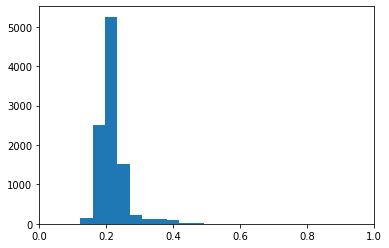

In [52]:
# there is a distribution of predictions before training:

preds = model.predict(x_test)
%matplotlib inline
plt.hist(preds)
plt.xlim(0,1)


In [53]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])

# shuffle data
indices = (np.arange(x_train.shape[0]))
np.random.shuffle(indices)
x_train, y_train = x_train[indices], y_train[indices]

from tensorflow.keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint(model_dir + 'best_text_bert.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min', 
                           save_weights_only=True)

history = model.fit(x_train, 
                    y_train, 
                    epochs=5, 
                    batch_size=100, 
                    validation_split=0.1,
                    callbacks=[mcp_save])#validation_data=(x_val, y_val))

Train on 121340 samples, validate on 13483 samples
Epoch 1/5
121340/121340 [==============================] - 2497s 21ms/sample - loss: 0.5291 - accuracy: 0.7678 - val_loss: 0.4754 - val_accuracy: 0.7888
Epoch 2/5
121340/121340 [==============================] - 2462s 20ms/sample - loss: 0.4914 - accuracy: 0.7829 - val_loss: 0.4732 - val_accuracy: 0.7848
Epoch 3/5
121340/121340 [==============================] - 2461s 20ms/sample - loss: 0.4827 - accuracy: 0.7846 - val_loss: 0.4682 - val_accuracy: 0.7905
Epoch 4/5
121340/121340 [==============================] - 2461s 20ms/sample - loss: 0.4747 - accuracy: 0.7885 - val_loss: 0.4665 - val_accuracy: 0.7907
Epoch 5/5
121340/121340 [==============================] - 2453s 20ms/sample - loss: 0.4676 - accuracy: 0.7924 - val_loss: 0.4739 - val_accuracy: 0.7885


In [55]:
model.load_weights(model_dir + 'best_text_bert.h5')

In [56]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

# get AUROC
preds = model.predict(x_test)
print('Test AUROC:', roc_auc_score(y_test, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0
print('Test acc:', accuracy_score(y_test, preds_bin))

# get F1
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test AUROC: 0.7398216000000001
Test acc: 0.6313
Test F1: 0.49123775355319443
Test Precision: 0.792167334223409
Test Recall: 0.356


(0.0, 1.0)

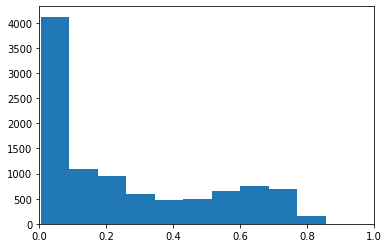

In [29]:
%matplotlib inline
plt.hist(preds)
plt.xlim(0,1)

In [30]:
model.save(model_dir + 'text_bert.h5')

In [61]:
print(x_train[0], y_train[0])

[  101  6343  6719  2025  1037  2309  3969  3449  5063  1028  2033  2613
  4632  7743  2507  1037  6616  1005 10094  1037  9152 23033  9377  1028
 24471  2140  1028   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] 0


In [58]:
print(preds)
print([n.item() for n in preds])

[[0.31512624]
 [0.2756195 ]
 [0.3323657 ]
 ...
 [0.7306908 ]
 [0.28707463]
 [0.776174  ]]
[0.3151262402534485, 0.2756195068359375, 0.3323656916618347, 0.7004018425941467, 0.41199660301208496, 0.7757275104522705, 0.2973950505256653, 0.33663028478622437, 0.3095695972442627, 0.7173013687133789, 0.76972895860672, 0.7126694321632385, 0.32424354553222656, 0.6755710244178772, 0.6654713153839111, 0.6912045478820801, 0.6483101844787598, 0.7317488193511963, 0.715315580368042, 0.29639768600463867, 0.6852844953536987, 0.7026669979095459, 0.33101239800453186, 0.7345011830329895, 0.699725329875946, 0.7874727249145508, 0.3497809171676636, 0.7271045446395874, 0.7533071041107178, 0.3300577402114868, 0.2845214009284973, 0.741745114326477, 0.6866323351860046, 0.7546931505203247, 0.7379428148269653, 0.6962660551071167, 0.2977783679962158, 0.3083829879760742, 0.7045806050300598, 0.7514084577560425, 0.36453670263290405, 0.3212031126022339, 0.6728568077087402, 0.3137681484222412, 0.6628589630126953, 0.730888

In [39]:
print(x_train[0])

[  101  2008  2015  2054  1057  2655  1037  2417 18278  8840  2140 24471
  2140  1028   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [ ]:
# shuffle data
indices = (np.arange(x_train.shape[0]))
np.random.shuffle(indices)
x_train, y_train = x_train[indices], y_train[indices]

In [24]:
tf.test.is_gpu_available()

True

In [6]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
# from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [8]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [9]:
train = train.append(valid).reset_index(drop=True)

In [10]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


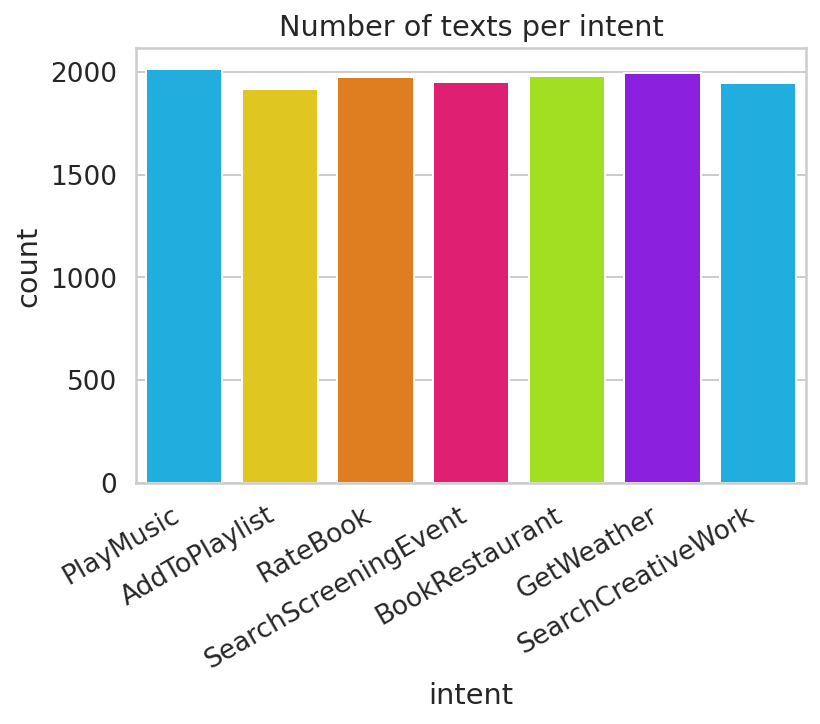

In [11]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [12]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("pretrained_bert_model")
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [13]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [14]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [15]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [16]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [17]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [18]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:05, 2698.99it/s]
700it [00:00, 2728.17it/s]


max seq_len 38


In [20]:
print(data.train_x.shape, data.train_x[0], data.train_y[0], data.max_seq_len)

(13784, 38) [  101  4952  2000  2225  3676  2213  2632 25438 27395  2006  8224  2189
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] 0 38


In [19]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: pretrained_bert_model/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fb421938208> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [22]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [25]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Train on 12405 samples, validate on 1379 samples
Epoch 1/5
12405/12405 [==============================] - 428s 35ms/sample - loss: 1.2562 - acc: 0.9259 - val_loss: 1.1854 - val_acc: 0.9790
Epoch 2/5
12405/12405 [==============================] - 423s 34ms/sample - loss: 1.1851 - acc: 0.9819 - val_loss: 1.1794 - val_acc: 0.9862
Epoch 3/5
12405/12405 [==============================] - 423s 34ms/sample - loss: 1.1803 - acc: 0.9859 - val_loss: 1.1790 - val_acc: 0.9869
Epoch 4/5
12405/12405 [==============================] - 424s 34ms/sample - loss: 1.1762 - acc: 0.9901 - val_loss: 1.1798 - val_acc: 0.9869
Epoch 5/5
12405/12405 [==============================] - 424s 34ms/sample - loss: 1.1758 - acc: 0.9898 - val_loss: 1.1809 - val_acc: 0.9840


In [26]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

13784/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

700/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

train acc 0.9918021
test acc 0.97571427


In [34]:
model.predict(data.test_x)

array([[3.3427369e-08, 9.9999928e-01, 2.6344617e-07, ..., 5.7458230e-08,
        2.1962791e-07, 2.3732190e-08],
       [3.4715876e-07, 5.6007025e-07, 5.4592510e-07, ..., 9.9999809e-01,
        2.2014434e-07, 8.7926956e-08],
       [4.4394849e-08, 9.9999905e-01, 4.0018517e-07, ..., 1.0802037e-07,
        3.5014858e-07, 2.0105855e-08],
       ...,
       [7.4600969e-08, 6.2744519e-08, 9.9999952e-01, ..., 1.0596871e-07,
        5.8851796e-08, 1.6153052e-08],
       [3.6961936e-08, 9.9999928e-01, 2.2366386e-07, ..., 6.6003714e-08,
        2.2522018e-07, 1.5751830e-08],
       [8.7670031e-08, 5.8158165e-08, 9.9999952e-01, ..., 9.3745292e-08,
        1.0747971e-07, 2.0062464e-08]], dtype=float32)